In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.layers import Dense, Dropout, LSTM, GRU, Bidirectional
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
# Data download
start = "2010-01-01"
end = "2024-07-01"

df = yf.download("AAPL", start = start, end = end)

[*********************100%***********************]  1 of 1 completed


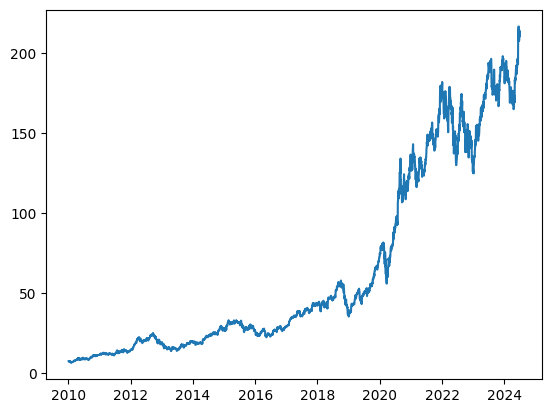

In [3]:
plt.plot(df.Close)

In [4]:
# Data preprocessing
df = df.reset_index()
df = df.drop(["Date", "Adj Close"], axis = 1)

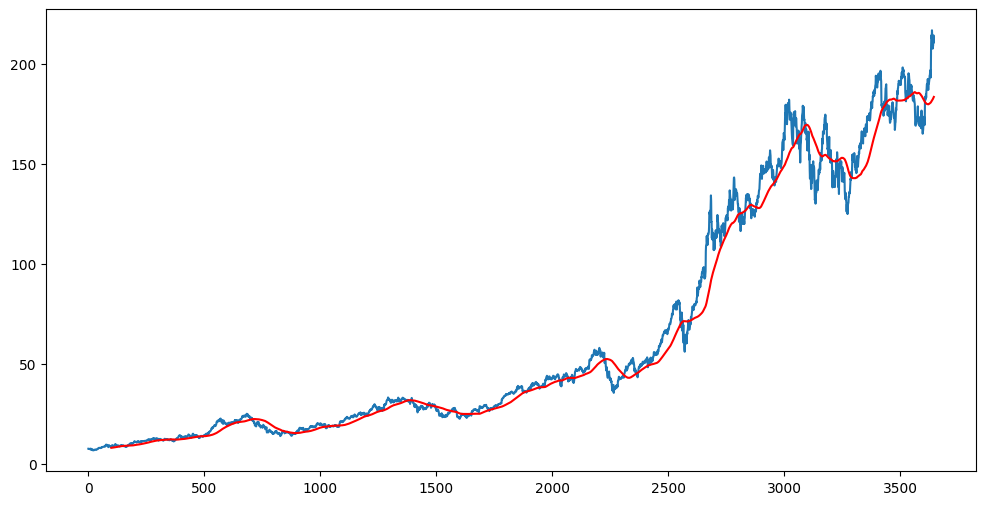

In [5]:
mov_avg100 = df.Close.rolling(100).mean()
plt.figure(figsize = (12,6))
plt.plot(df.Close)
plt.plot(mov_avg100, "r")

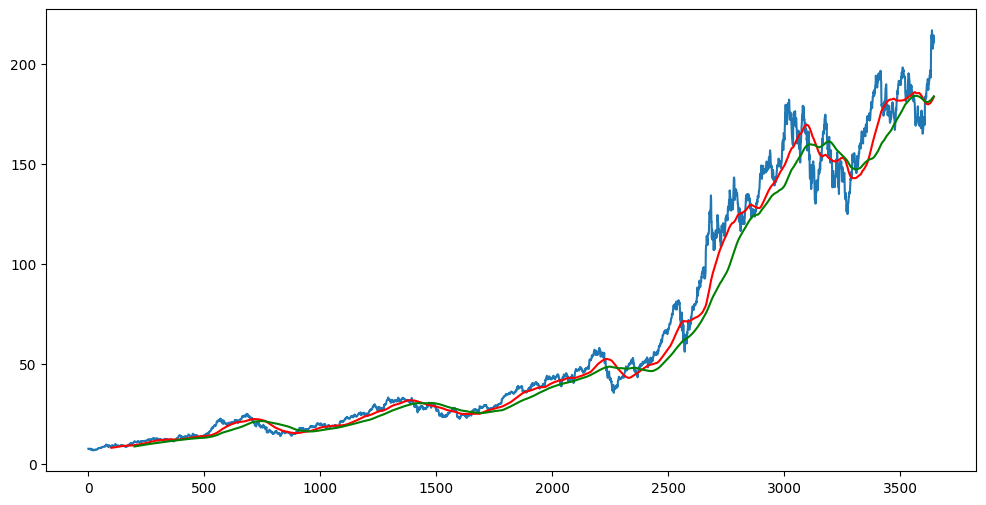

In [6]:
mov_avg200 = df.Close.rolling(200).mean()
plt.figure(figsize = (12,6))
plt.plot(df.Close)
plt.plot(mov_avg100, "r")
plt.plot(mov_avg200, "g")

In [7]:
# Splitting our data into training and testing set
train_size = int(len(df) * 0.7)
train_data = df[:train_size]
test_data = df[train_size:]

X_train, y_train = [], []
X_test, y_test = [], []

In [8]:
# Data Scaling
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (0,1))
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

In [9]:
# Creating our train and test vectors
window_size = 150

for i in range(window_size, len(train_data)):
    X_train.append(train_data[i - window_size : i, 0])
    y_train.append(train_data[i, 0])

for i in range(window_size, len(test_data)):
    X_test.append(test_data[i - window_size : i, 0])
    y_test.append(test_data[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

In [10]:
# Reshaping the data
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [11]:
# Model Building
model = Sequential()

model.add(Bidirectional(LSTM(units = 60, return_sequences = True, input_shape = (X_train.shape[1], 1)))) # trains two LSTMs on the input sequence, one on the regular input and one on the reversed input. This allows the network to have information from both past and future states simultaneously
model.add(Dropout(0.2))
model.add(LSTM(units=80, return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(units = 100))
model.add(Dropout(0.4))
model.add(Dense(units = 1))

model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:
# Callbacks for Early Stopping and Learning Rate Reduction
early_stop = EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True) # prevent overfitting by stopping the training process when the models performance stops improving
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', patience = 5, factor = 0.5, min_lr = 1e-5) # reduces learning rate to allow for finer adjustments if the models performance stops improving

In [13]:
# Training the model
history = model.fit(X_train, y_train, epochs = 100, validation_data = (X_test, y_test), callbacks = [early_stop, reduce_lr], batch_size = 32)

Epoch 1/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 39s 404ms/step - loss: 0.0196 - val_loss: 0.1011 - learning_rate: 0.0010
Epoch 2/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 41s 407ms/step - loss: 0.0017 - val_loss: 0.0833 - learning_rate: 0.0010
Epoch 3/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 42s 417ms/step - loss: 0.0019 - val_loss: 0.0613 - learning_rate: 0.0010
Epoch 4/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 39s 392ms/step - loss: 0.0018 - val_loss: 0.0276 - learning_rate: 0.0010
Epoch 5/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 44s 439ms/step - loss: 0.0014 - val_loss: 0.0311 - learning_rate: 0.0010
Epoch 6/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 37s 393ms/step - loss: 0.0014 - val_loss: 0.0515 - learning_rate: 0.0010
Epoch 7/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 44s 432ms/step - loss: 0.0013 - val_loss: 0.0079 - learning_rate: 0.0010
Epoch 8/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 29s 384ms/step - loss: 0.0013 - val_loss: 0.0526 - learning_rate: 0.0010
Epoch 9/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 41s 386ms/step - loss: 0.0015 - val_loss: 0.0243 - learning_rate:

In [14]:
# Model Summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 150, 120)            │          29,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 150, 120)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 150, 80)             │          64,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 150, 80)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 100)                 │          54,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 446,345 (1.70 MB)

 Trainable params: 148,781 (581.18 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 297,564 (1.14 MB)

In [15]:
# Save the model
model.save("LSTM_model.h5")

In [17]:
df

,Open,High,Low,Close,Volume
0,7.622500,7.660714,7.585000,7.643214,493729600
1,7.664286,7.699643,7.616071,7.656429,601904800
2,7.656429,7.686786,7.526786,7.534643,552160000
3,7.562500,7.571429,7.466071,7.520714,477131200
4,7.510714,7.571429,7.466429,7.570714,447610800
...,...,...,...,...,...
3641,207.720001,212.699997,206.589996,208.139999,80727000
3642,209.149994,211.380005,208.610001,209.070007,56713900
3643,211.500000,214.860001,210.639999,213.250000,66213200
3644,214.690002,215.740005,212.350006,214.100006,49772700


In [18]:
# Predicting
y_pred = model.predict(X_test)

close_column_index = 3

min_value = scaler.data_min_[close_column_index]
max_value = scaler.data_max_[close_column_index]

value_range = max_value - min_value

# Inverse Scaling (min max scaling -> X' = (X - Xmin)/(Xmax - Xmin))
y_pred_no_scale = (y_pred * value_range) + min_value
y_test_no_scale = (y_test * value_range) + min_value

30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step


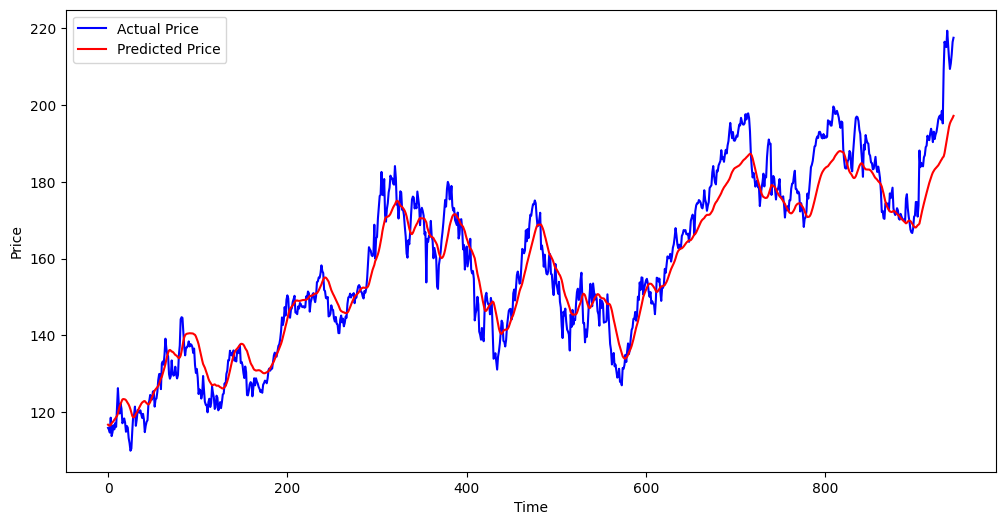

In [19]:
#Plot predicted vs actual prices
plt.figure(figsize=(12,6))
plt.plot(y_test_no_scale, "b", label = "Actual Price")
plt.plot(y_pred_no_scale, "r", label = "Predicted Price")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()